In [ ]:
!pip install ibllib one-api EMD-signal torch scikit-learn pykalman tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.3/993.3 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s 

In [ ]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [ ]:
from one.api import ONE
one = ONE()

# Example: search and select a session
eid = "c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9"
probe = 'probe00'

dsets = one.list_datasets(eid, collection=f'raw_ephys_data/{probe}', filename='*.lf.*')
data_files, _ = one.load_datasets(eid, dsets, download_only=True)

100%|██████████| 11/11.0 [00:16<00:00,  1.47s/it]


In [ ]:
bin_file = next(df for df in data_files if df.suffix == '.cbin')
import spikeglx
# Use spikeglx reader to read in the whole raw data
sr = spikeglx.Reader(bin_file)
print(sr.shape)

(10102582, 385)


In [ ]:
wheel = one.load_object(eid, 'wheel')
wheel_time = wheel.timestamps



# Compute wheel velocity
wheel_position = wheel.position

import numpy as np
wheel_velocity = np.gradient(wheel_position, wheel_time)


In [ ]:
fs_lfp = sr.fs
startIndex = int(00 * fs_lfp)
time_frame_in_seconds= startIndex + 3000
print(f"LFP sampling rate: {fs_lfp} Hz")
samplingIndex = int(fs_lfp * time_frame_in_seconds)
raw_lfp =sr.read(nsel = slice(startIndex,samplingIndex),csel =slice(0,384))[0]


LFP sampling rate: 2500.0 Hz


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
raw_lfp_scaled= scaler.fit_transform(raw_lfp)
channel_variance = np.var(raw_lfp_scaled, axis=0)
N = 64  # pick top 64 channels
top_n_indices = np.argsort(channel_variance)[-N:]
raw_lfp_scaled = raw_lfp_scaled[:, top_n_indices]

In [ ]:
import numpy as np

def bin_raw_lfp_by_wheel_times(raw_lfp, wheel_times, fs_lfp):
    bins = []

    # Start from t = 0
    prev_idx = 0

    for t in wheel_times:
        curr_idx = int(t * fs_lfp)

        if curr_idx > raw_lfp.shape[0]:
            break

        bin_data = raw_lfp[prev_idx:curr_idx]
        bins.append(bin_data)

        prev_idx = curr_idx

    return bins


fs_lfp = 2500

binned_lfp = bin_raw_lfp_by_wheel_times(raw_lfp_scaled, wheel_time, fs_lfp)

print(f"Number of bins: {len(binned_lfp)}")
for i, b in enumerate(binned_lfp[:3]):
    print(f"Bin {i}: {b.shape}")


Number of bins: 882795
Bin 0: (173, 64)
Bin 1: (132, 64)
Bin 2: (208, 64)


In [ ]:
import numpy as np
from scipy.stats import kurtosis, skew, entropy

def extract_features_from_binned_lfp(binned_lfp_batch, fs_lfp=2500):
    """
    Args:
        binned_lfp_batch: List of arrays [(samples_in_bin1, 384), (samples_in_bin2, 384), ...]
    Returns:
        features: List of (384, 9) arrays (one per bin)
    """

    all_bin_features = []

    for lfp_bin in binned_lfp_batch:
        if lfp_bin.shape[0] < 2:
            # Bin too small
            feature_array = np.zeros((lfp_bin.shape[1], 9), dtype=np.float32)
        else:
            feature_list = []
            for ch in range(lfp_bin.shape[1]):
                signal = lfp_bin[:, ch]
                mean = np.mean(signal)
                std = np.std(signal)
                minimum = np.min(signal)
                maximum = np.max(signal)
                energy = np.log1p(np.sum(signal**2))
                skewness = skew(signal)
                kurt = kurtosis(signal)

                # Zero crossing rate
                zcr = ((np.diff(np.sign(signal)) != 0).sum()) / (len(signal) + 1e-6)

                # Entropy
                hist, _ = np.histogram(signal, bins=50, density=True)
                hist = hist + 1e-8
                ent = entropy(hist)


                ch_features = [mean, std, minimum, maximum, energy, skewness, kurt, zcr, ent]
                feature_list.append(ch_features)

            feature_array = np.stack(feature_list, axis=0)

        all_bin_features.append(feature_array)

    return all_bin_features


In [ ]:
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def extract_features_from_bin(lfp_bin):
    """
    Given a single LFP bin (samples, channels), compute features per channel.
    If the bin is empty or too small, return zeros.
    """
    if lfp_bin.ndim != 2 or lfp_bin.shape[0] < 2:
        return np.zeros((lfp_bin.shape[1] if lfp_bin.ndim == 2 else 384, 9), dtype=np.float32)

    n_channels = lfp_bin.shape[1]
    feats = []

    for ch in range(n_channels):
        signal = lfp_bin[:, ch]

        ch_feats = [
            np.mean(signal),
            np.std(signal),
            np.min(signal),
            np.max(signal),
            np.median(signal),
            np.percentile(signal, 25),
            np.percentile(signal, 75),
            np.sum(signal ** 2),
            np.mean(np.diff(signal)**2)
        ]

        feats.append(ch_feats)

    return np.array(feats, dtype=np.float32)

def parallel_feature_extraction(lfp_bins):
    """
    Parallel feature extraction with tqdm progress bar.
    """
    with Pool(processes=cpu_count()) as pool:
        features = list(tqdm(pool.imap(extract_features_from_bin, lfp_bins), total=len(lfp_bins)))
    return np.array(features, dtype=np.float32)

# --- Usage ---

print(f"Extracting features from {len(binned_lfp)} bins using {cpu_count()} cores...")
X_features = parallel_feature_extraction(binned_lfp)
print("Done! Final feature matrix shape:", X_features.shape)


Extracting features from 882795 bins using 8 cores...


100%|██████████| 882795/882795 [36:15<00:00, 405.70it/s]


Done! Final feature matrix shape: (882795, 64, 9)


In [ ]:
import numpy as np

def compute_wheel_velocity(wheel_position, wheel_time, cutoff_sec=None):
    """
    Compute wheel velocity (dtheta/dt) from position and time.

    Args:
        wheel_position: np.array, shape (N,)
        wheel_time: np.array, shape (N,)
        cutoff_sec: float, optional cutoff time in seconds

    Returns:
        velocity: np.array, shape (M,), where M <= N
        time_stamps: np.array, shape (M,), matching velocity
    """

    if cutoff_sec is not None:
        mask = wheel_time <= cutoff_sec
        wheel_position = wheel_position[mask]
        wheel_time = wheel_time[mask]

    # Compute differences
    dtheta = np.diff(wheel_position)    # change in position
    dt = np.diff(wheel_time)             # change in time

    # Avoid division by zero
    dt[dt == 0] = 1e-8

    velocity = dtheta / dt  # rad/sec or whatever unit
    time_stamps = wheel_time[1:]  # aligned with velocity

    return velocity, time_stamps


In [ ]:
velocity, timestamps = compute_wheel_velocity(wheel_position, wheel_time, cutoff_sec=3000)

print(velocity.shape)   # (N-1,)
print(timestamps.shape) # (N-1,)


(882794,)
(882794,)


In [ ]:
X = X_features[:-1]

print(X.shape)

(882794, 64, 9)


In [ ]:
X = X.reshape(X.shape[0], -1)

In [ ]:
print(X.shape)

(211282, 576)


In [ ]:
y = velocity
import numpy as np
np.save('X.npy', X)
np.save('y.npy', velocity)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# --- Step 1: Prepare Data ---
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Dataset split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

# --- Step 2: Transformer Model ---
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, latent_dim=256, nhead=8, num_layers=4, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=latent_dim,
            nhead=nhead,
            dim_feedforward=latent_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.mlp_regressor = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):  # x: (B, F)
        x = self.input_proj(x)  # (B, latent_dim)
        x = x.unsqueeze(1)      # (B, 1, latent_dim)
        x = self.transformer_encoder(x)  # (B, 1, latent_dim)
        x = x.squeeze(1)        # (B, latent_dim)
        return self.mlp_regressor(x).squeeze(1)  # (B,)

# --- Step 3: Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = TransformerRegressor(input_dim=X.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# --- Step 4: Training Loop ---
print("Starting training...")
for epoch in range(40):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



Using device: cuda
Starting training...
Epoch 01 | Train Loss: 9.8361 | Val Loss: 9.6932
Epoch 02 | Train Loss: 9.6837 | Val Loss: 9.6772
Epoch 03 | Train Loss: 9.6320 | Val Loss: 9.6695
Epoch 04 | Train Loss: 9.5986 | Val Loss: 9.5923
Epoch 05 | Train Loss: 9.5721 | Val Loss: 9.6467
Epoch 06 | Train Loss: 9.5519 | Val Loss: 9.5520
Epoch 07 | Train Loss: 9.5271 | Val Loss: 9.4966
Epoch 08 | Train Loss: 9.5135 | Val Loss: 9.5278
Epoch 09 | Train Loss: 9.4924 | Val Loss: 9.5077
Epoch 10 | Train Loss: 9.4735 | Val Loss: 9.4914
Epoch 11 | Train Loss: 9.4602 | Val Loss: 9.8400
Epoch 12 | Train Loss: 9.4521 | Val Loss: 9.5231
Epoch 13 | Train Loss: 9.4373 | Val Loss: 9.4888
Epoch 14 | Train Loss: 9.4221 | Val Loss: 9.4963
Epoch 15 | Train Loss: 9.4129 | Val Loss: 9.7027
Epoch 16 | Train Loss: 9.4008 | Val Loss: 9.4808
Epoch 17 | Train Loss: 9.3904 | Val Loss: 9.7634
Epoch 18 | Train Loss: 9.3738 | Val Loss: 9.4640
Epoch 19 | Train Loss: 9.3708 | Val Loss: 9.4364
Epoch 20 | Train Loss: 9.3589


5-Fold Cross Validation on Test Set...
Fold 1: R²=0.0924, RMSE=3.0398, MAE=2.1962


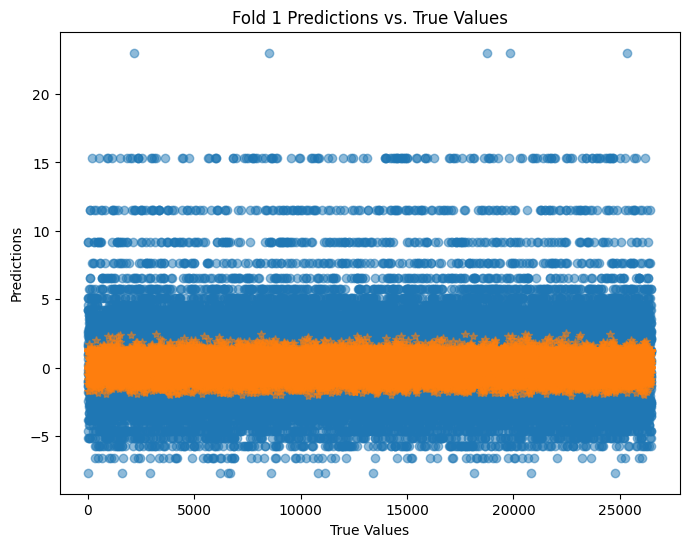

Fold 2: R²=0.0937, RMSE=3.0534, MAE=2.1973


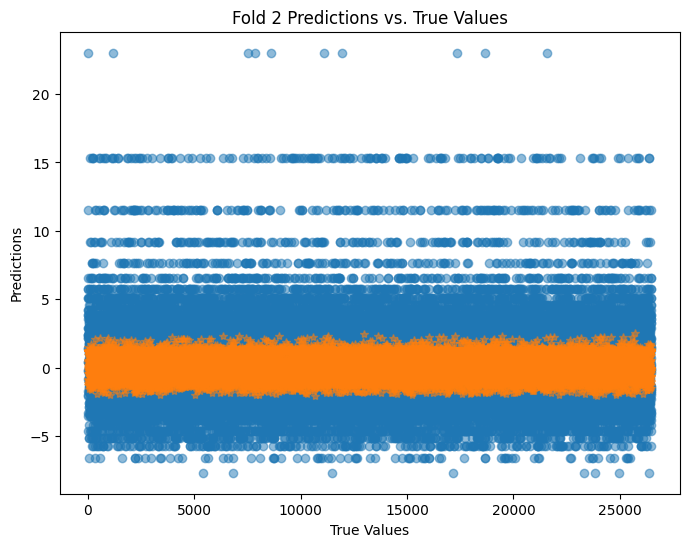

Fold 3: R²=0.0941, RMSE=3.0608, MAE=2.2048


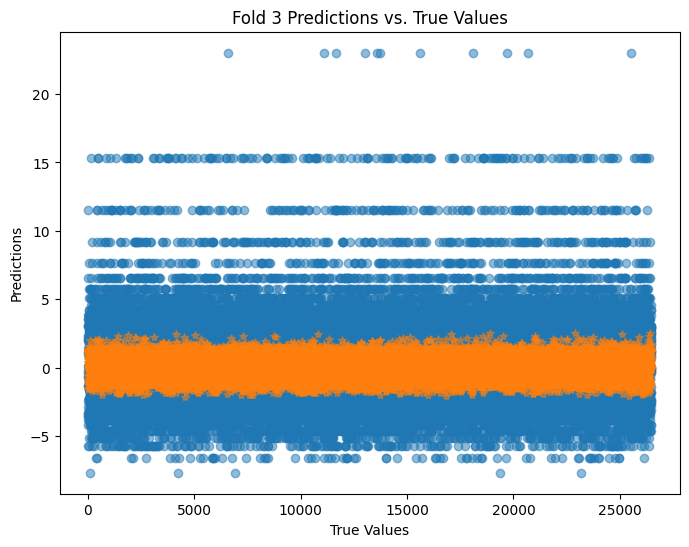

Fold 4: R²=0.0889, RMSE=3.0500, MAE=2.2091


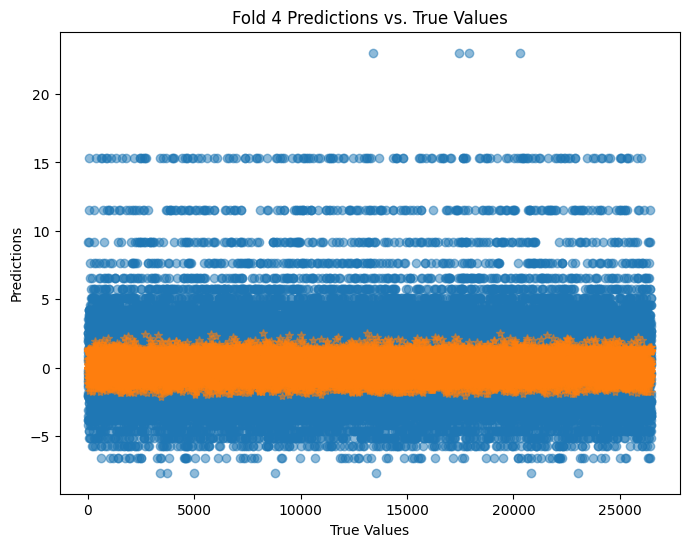

Fold 5: R²=0.0870, RMSE=3.0810, MAE=2.2298


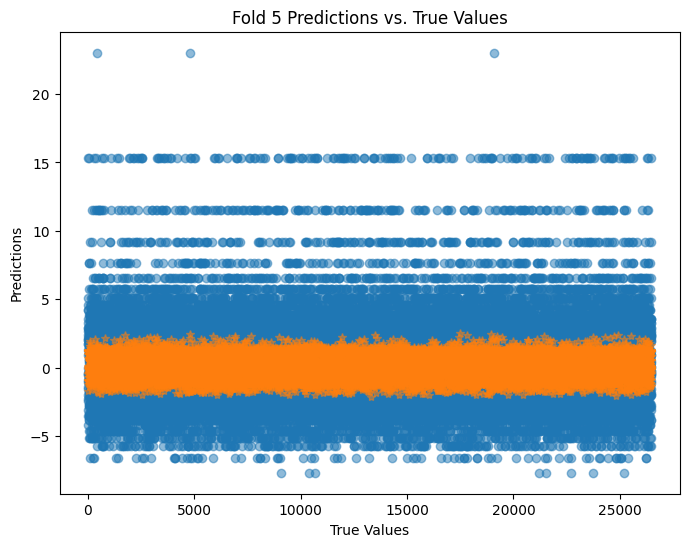


Test Set CV Results:
Mean R²:   0.0912 ± 0.0028
Mean RMSE: 3.0570
Mean MAE:  2.2074


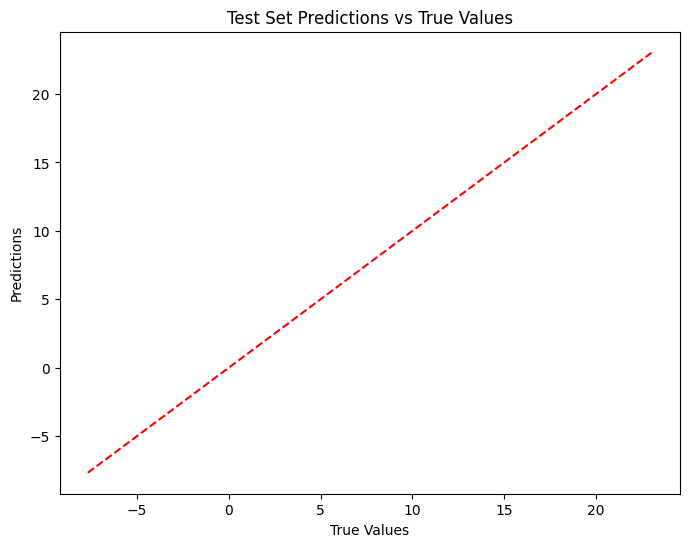

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print("\n5-Fold Cross Validation on Test Set...")
z_test_tensor = torch.stack([ex[0] for ex in test_ds]).to(device)
y_test_tensor = torch.stack([ex[1] for ex in test_ds]).to(device)


kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2s, rmses, maes = [], [], []

model.eval()
with torch.no_grad():
    for fold, (train_idx, test_idx) in enumerate(kf.split(z_test_tensor)):
        Z_te = z_test_tensor[test_idx].to(device)
        y_te = y_test_tensor[test_idx].to(device)

        preds = model(Z_te).cpu().numpy()
        targets = y_te.cpu().numpy()

        r2 = r2_score(targets, preds)
        mse = mean_squared_error(targets, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, preds)

        print(f"Fold {fold+1}: R²={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
        r2s.append(r2)
        rmses.append(rmse)
        maes.append(mae)
        plt.figure(figsize=(8, 6))
        plt.plot(targets, 'o', alpha=0.5)
        plt.plot(preds, '*', alpha=0.5)
        # Add diagonal line
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        plt.title(f"Fold {fold + 1} Predictions vs. True Values")
        plt.show()


print("\nTest Set CV Results:")
print(f"Mean R²:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
print(f"Mean RMSE: {np.mean(rmses):.4f}")
print(f"Mean MAE:  {np.mean(maes):.4f}")
plt.figure(figsize=(8, 6))
plt.plot([min(y_test_tensor.cpu().numpy()), max(y_test_tensor.cpu().numpy())], [min(y_test_tensor.cpu().numpy()), max(y_test_tensor.cpu().numpy())], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Test Set Predictions vs True Values")
plt.show()


## Classification

In [ ]:
trials = one.load_object(eid, 'trials')

# Extract choice data
choice = trials['choice']
choice_time = trials['goCueTrigger_times']


In [ ]:
import numpy as np

def bin_raw_lfp_by_wheel_times(raw_lfp, wheel_times, fs_lfp):
    bins = []

    # Start from t = 0
    prev_idx = 0

    for t in wheel_times:
        curr_idx = int(t * fs_lfp)

        if curr_idx > raw_lfp.shape[0]:  # avoid going beyond LFP
            break

        bin_data = raw_lfp[prev_idx:curr_idx]  # (samples, 384)
        bins.append(bin_data)

        prev_idx = curr_idx

    return bins  # List of np.arrays

# Example Usage
fs_lfp = 2500  # LFP sampling rate (adjust to your actual value)

binned_lfp_classification = bin_raw_lfp_by_wheel_times(raw_lfp_scaled, choice_time, fs_lfp)

print(f"Number of bins: {len(raw_lfp_scaled)}")
for i, b in enumerate(raw_lfp_scaled[:3]):
    print(f"Bin {i}: {b.shape}")  # (samples_in_bin, 384)


Number of bins: 7500000
Bin 0: (64,)
Bin 1: (64,)
Bin 2: (64,)


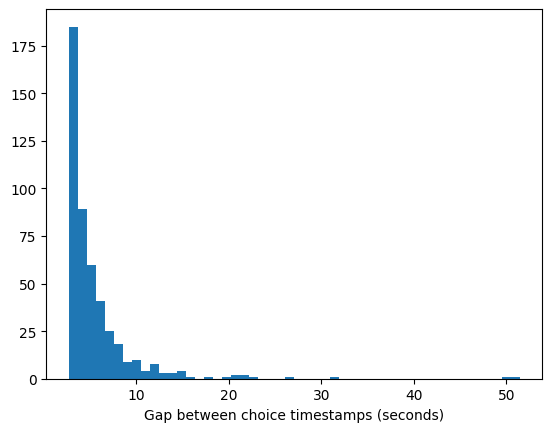

In [ ]:
gaps = np.diff(choice_time)
import matplotlib.pyplot as plt
plt.hist(gaps, bins=50)
plt.xlabel("Gap between choice timestamps (seconds)")
plt.show()

Number of choice events: 472
Number of gaps: 471
Min gap: 2.666808 sec
Mean gap: 5.524795 sec
Max gap: 51.432447 sec


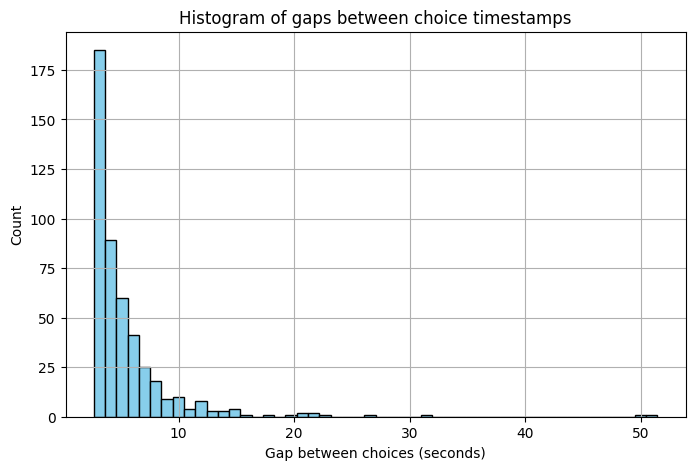

Number of gaps smaller than 0.1 sec: 0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming choice_time is your array of timestamps (in seconds)

# 1. Compute differences (gaps) between consecutive choice times
gaps = np.diff(choice_time)  # choice_time should be a 1D array/list

# 2. Print some quick stats
print(f"Number of choice events: {len(choice_time)}")
print(f"Number of gaps: {len(gaps)}")
print(f"Min gap: {gaps.min():.6f} sec")
print(f"Mean gap: {gaps.mean():.6f} sec")
print(f"Max gap: {gaps.max():.6f} sec")

# 3. Plot histogram of gaps
plt.figure(figsize=(8,5))
plt.hist(gaps, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Gap between choices (seconds)")
plt.ylabel("Count")
plt.title("Histogram of gaps between choice timestamps")
plt.grid(True)
plt.show()

# 4. Optional: See how many are very small
tiny_gap_threshold = 0.1  # say, 0.1 seconds
tiny_gaps = np.sum(gaps < tiny_gap_threshold)
print(f"Number of gaps smaller than {tiny_gap_threshold} sec: {tiny_gaps}")


In [ ]:
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from scipy.stats import skew, kurtosis

# --- Feature Extraction Function ---
def extract_features_from_bin(lfp_bin):
    """Extract basic features from each channel of a single LFP bin."""
    features = []
    for ch in range(lfp_bin.shape[1]):
        signal = lfp_bin[:, ch]
        if len(signal) < 2:
            # Empty or tiny bin, put zeros
            features.extend([0, 0, 0, 0, 0])
        else:
            features.extend([
                np.mean(signal),
                np.std(signal),
                np.min(signal),
                np.max(signal),
                np.sum(signal**2),
                # skew(signal),            # Optional
                # kurtosis(signal),         # Optional
            ])
    return np.array(features, dtype=np.float32)

# --- Binning and Label Assignment ---
def bin_lfp_and_assign_labels(raw_lfp, choice_times, choices, fs_lfp):
    """
    Bin the LFP based on choice times and assign labels correctly.
    Returns:
        X_features: (N_bins, Features)
        y_labels: (N_bins,)
    """
    X_features = []
    y_labels = []

    start_time = 0
    for i in tqdm(range(len(choice_times))):
        end_time = choice_times[i]
        start_idx = int(start_time * fs_lfp)
        end_idx = int(end_time * fs_lfp)

        if end_idx > raw_lfp.shape[0]:  # Avoid overflow
            break

        lfp_bin = raw_lfp[start_idx:end_idx]  # (samples, channels)

        if lfp_bin.shape[0] < 2:
            # Skip empty bins
            continue

        feats = extract_features_from_bin(lfp_bin)
        X_features.append(feats)
        y_labels.append(choices[i])  # Label is choice[i]

        start_time = end_time  # Update for next bin

    X_features = np.array(X_features, dtype=np.float32)
    y_labels = np.array(y_labels, dtype=np.float32)

    return X_features, y_labels

# --- Your Inputs ---
# raw_lfp_scaled: (time_samples, 384)  # already loaded
# choice_time: array of timestamps (seconds)
# choice: array of -1 and 1
fs_lfp = 2500  # sampling rate (Hz)

print("Binning raw LFP and assigning labels...")
X_features, y_labels = bin_lfp_and_assign_labels(raw_lfp_scaled, choice_time, choice, fs_lfp)

print(f"\nFinal X shape: {X_features.shape}, y shape: {y_labels.shape}")
print(f"Unique labels: {np.unique(y_labels)}")


Binning raw LFP and assigning labels...


100%|██████████| 472/472 [00:02<00:00, 192.55it/s]


Final X shape: (472, 320), y shape: (472,)
Unique labels: [-1.  1.]


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# --- Step 1: Preprocess Labels (convert -1 to 0) ---
y_labels_bin = (y_labels == 1).astype(np.int64)  # Now labels are {0, 1}

# --- Step 2: Train/Validation/Test Split ---
X_tensor = torch.tensor(X_features, dtype=torch.float32)
y_tensor = torch.tensor(y_labels_bin, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# --- Step 3: Define Logistic Regression Model ---
class LogisticRegressionClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 2)  # 2 classes

    def forward(self, x):
        return self.linear(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LogisticRegressionClassifier(input_dim=X_features.shape[1]).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

# --- Step 4: Training Loop ---
print("Starting Training...")
for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(yb.cpu().numpy())
    val_loss /= len(val_loader)

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# --- Step 5: 5-Fold Cross-Validation on Test Set ---
print("\n5-Fold Cross Validation on Test Set...")

X_test = torch.stack([ex[0] for ex in test_ds]).cpu().numpy()
y_test = torch.stack([ex[1] for ex in test_ds]).cpu().numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s = [], []

with torch.no_grad():
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_test)):
        X_fold = torch.tensor(X_test[train_idx], dtype=torch.float32).to(device)
        y_fold = torch.tensor(y_test[train_idx], dtype=torch.long).to(device)

        X_val_fold = torch.tensor(X_test[test_idx], dtype=torch.float32).to(device)
        y_val_fold = torch.tensor(y_test[test_idx], dtype=torch.long).to(device)

        preds = model(X_val_fold)
        preds_cls = preds.argmax(dim=1)

        acc = accuracy_score(y_val_fold.cpu(), preds_cls.cpu())
        f1 = f1_score(y_val_fold.cpu(), preds_cls.cpu(), average='binary')

        print(f"Fold {fold+1}: Acc={acc:.4f}, F1={f1:.4f}")
        accs.append(acc)
        f1s.append(f1)

print("\nFinal Test Set CV Results:")
print(f"Mean Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean F1: {np.mean(f1s):.4f}")


Starting Training...
Epoch 01 | Train Loss: 796.4259 | Val Loss: 669.1650 | Val Acc: 0.4286
Epoch 02 | Train Loss: 445.0681 | Val Loss: 111.0763 | Val Acc: 0.4571
Epoch 03 | Train Loss: 151.2453 | Val Loss: 135.2490 | Val Acc: 0.4143
Epoch 04 | Train Loss: 191.8431 | Val Loss: 90.1304 | Val Acc: 0.4714
Epoch 05 | Train Loss: 135.0516 | Val Loss: 76.3185 | Val Acc: 0.4571
Epoch 06 | Train Loss: 146.2051 | Val Loss: 248.7966 | Val Acc: 0.4143
Epoch 07 | Train Loss: 178.6594 | Val Loss: 60.6178 | Val Acc: 0.4286
Epoch 08 | Train Loss: 135.8091 | Val Loss: 118.2158 | Val Acc: 0.5286
Epoch 09 | Train Loss: 109.8908 | Val Loss: 134.8341 | Val Acc: 0.4286
Epoch 10 | Train Loss: 118.5185 | Val Loss: 51.0751 | Val Acc: 0.4714
Epoch 11 | Train Loss: 114.8109 | Val Loss: 165.8035 | Val Acc: 0.6000
Epoch 12 | Train Loss: 210.8757 | Val Loss: 413.8005 | Val Acc: 0.4286
Epoch 13 | Train Loss: 234.0523 | Val Loss: 93.4744 | Val Acc: 0.4571
Epoch 14 | Train Loss: 174.7874 | Val Loss: 44.5386 | Val Acc

In [ ]:
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def extract_features_from_bin(lfp_bin):
    """
    Given a single LFP bin (samples, channels), compute features per channel.
    If the bin is empty or too small, return zeros.
    """
    if lfp_bin.ndim != 2 or lfp_bin.shape[0] < 2:
        return np.zeros((lfp_bin.shape[1] if lfp_bin.ndim == 2 else 384, 9), dtype=np.float32)

    n_channels = lfp_bin.shape[1]
    feats = []

    for ch in range(n_channels):
        signal = lfp_bin[:, ch]

        ch_feats = [
            np.mean(signal),
            np.std(signal),
            np.min(signal),
            np.max(signal),
            np.median(signal),
            np.percentile(signal, 25),
            np.percentile(signal, 75),
            np.sum(signal ** 2),
            np.mean(np.diff(signal)**2)
        ]

        feats.append(ch_feats)

    return np.array(feats, dtype=np.float32)

def parallel_feature_extraction(lfp_bins):
    """
    Parallel feature extraction with tqdm progress bar.
    """
    with Pool(processes=cpu_count()) as pool:
        features = list(tqdm(pool.imap(extract_features_from_bin, lfp_bins), total=len(lfp_bins)))
    return np.array(features, dtype=np.float32)

# --- Usage ---

print(f"Extracting features from {len(binned_lfp)} bins using {cpu_count()} cores...")
X_features = parallel_feature_extraction(binned_lfp_classification)
print("Done! Final feature matrix shape:", X_features.shape)


Extracting features from 130 bins using 8 cores...


100%|██████████| 130/130 [00:02<00:00, 57.90it/s]

Done! Final feature matrix shape: (130, 64, 9)


In [ ]:
binary_labels = (choice == 1).astype(np.int64)

In [ ]:
y = binary_labels

In [ ]:
X = X_features.reshape(X_features.shape[0], -1)


In [ ]:
X.shape

(130, 576)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Parameters
fs = 2500  # sampling frequency
window_size = int(fs * 0.25)  # 250 ms
step = window_size // 2  # 50% overlap

# Generate overlapping time windows
lfp_windows = [
    lfp_filtered[start:start + window_size]
    for start in range(0, lfp_filtered.shape[0] - window_size, step)
]

# Compute correlation matrix for each window and accumulate
corr_matrices = []
for win in tqdm(lfp_windows):
    if win.shape[0] >= 2:  # at least 2 samples required for correlation
        corr = np.corrcoef(win.T)
        corr_matrices.append(corr)

# Average correlation across time bins
mean_corr = np.mean(corr_matrices, axis=0)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(mean_corr, cmap='coolwarm', center=0, square=True,
            xticklabels=False, yticklabels=False, cbar_kws={'label': 'Correlation'})
plt.title("Mean Channel Correlation Across Time Bins")
plt.tight_layout()
plt.show()


In [ ]:
wheel_velocity.shape

(1250,)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
raw_lfp_scaled= scaler.fit_transform(raw_lfp)
# lfp_filtered: shape (T, C)
channel_variance = np.var(raw_lfp_scaled, axis=0)  # shape: (C,)
N = 64  # pick top 64 channels
top_n_indices = np.argsort(channel_variance)[-N:]

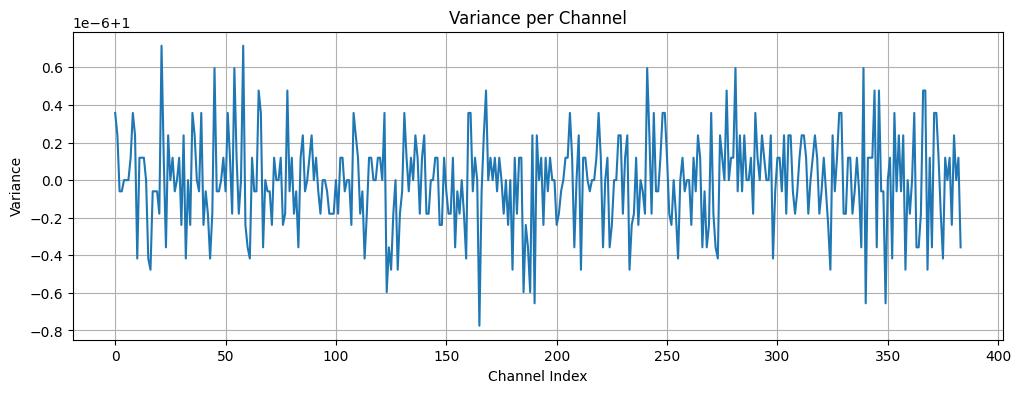

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(channel_variance)), channel_variance)
plt.xlabel("Channel Index")
plt.ylabel("Variance")
plt.title("Variance per Channel")
plt.grid(True)
plt.show()


100%|██████████| 24184/24184 [00:07<00:00, 3152.92it/s]


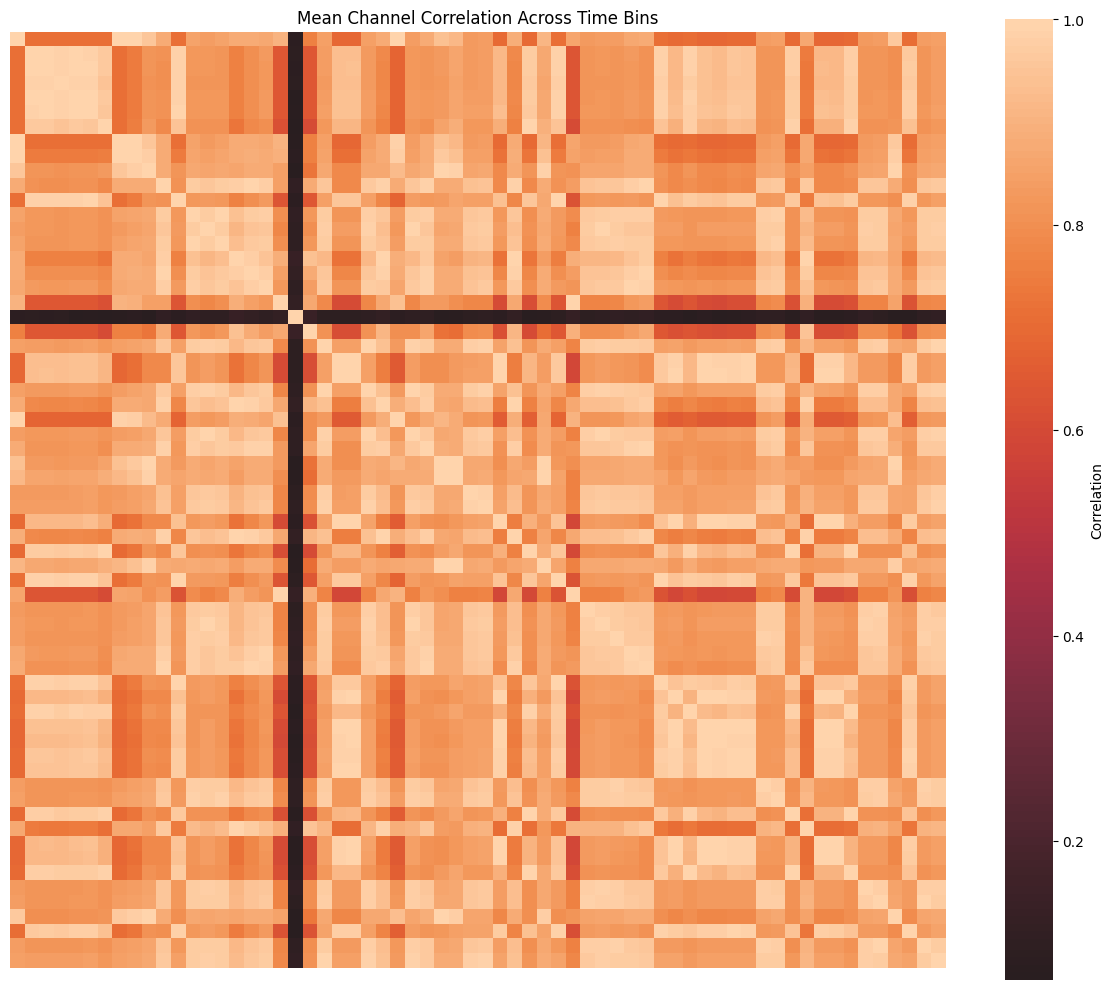

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

lfp_filtered = raw_lfp_scaled[:, top_n_indices]
# Parameters
fs = 2500  # sampling frequency
window_size = int(fs * 0.25)  # 250 ms
step = window_size // 10  # 50% overlap

# Generate overlapping time windows
lfp_windows = [
    lfp_filtered[start:start + window_size]
    for start in range(0, lfp_filtered.shape[0] - window_size, step)
]

# Compute correlation matrix for each window and accumulate
corr_matrices = []

for win in tqdm(lfp_windows):
    if win.shape[0] >= 2:  # at least 2 samples required for correlation
        corr = np.corrcoef(win.T)
        corr_matrices.append(corr)

# Average correlation across time bins
mean_corr = np.mean(corr_matrices, axis=0)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(mean_corr, center=0, square=True,
            xticklabels=False, yticklabels=False, cbar_kws={'label': 'Correlation'})
plt.title("Mean Channel Correlation Across Time Bins")
plt.tight_layout()
plt.show()


In [ ]:
lfp_filtered.shape

(750000, 64)

In [ ]:
len(lfp_windows)

12087

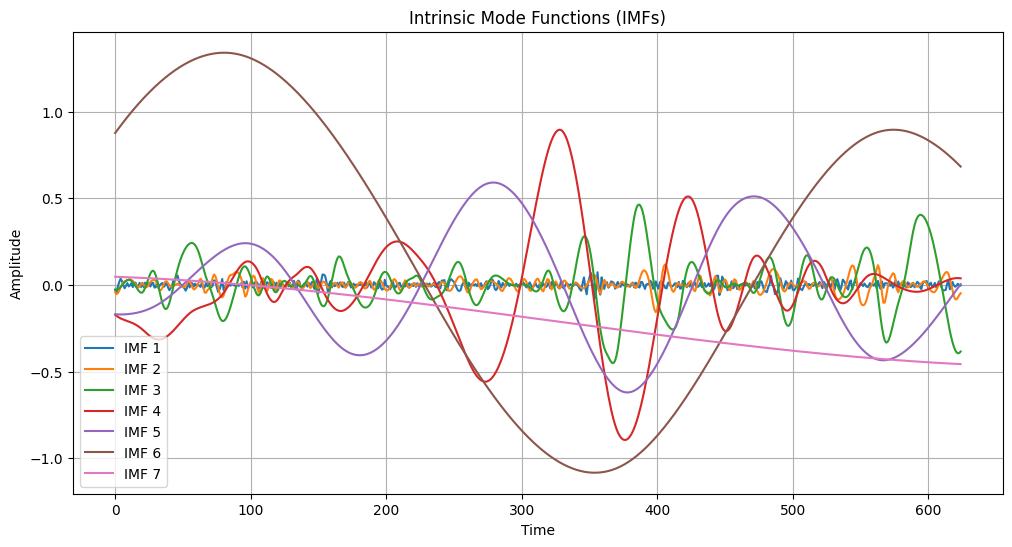

In [ ]:
# prompt: plot the above imfs waveforms

import matplotlib.pyplot as plt

# Assuming 'imfs' is defined as in your previous code (EMD decomposition)
plt.figure(figsize=(12, 6))
for i in range(imfs.shape[0]):
    plt.plot(imfs[i], label=f"IMF {i+1}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Intrinsic Mode Functions (IMFs)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
raw_lfp_scaled.shape

(1500000, 384)

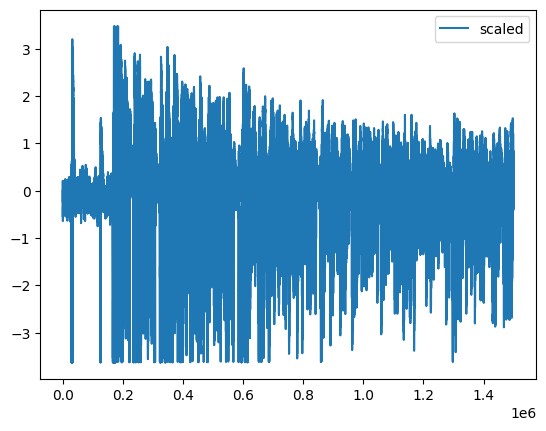

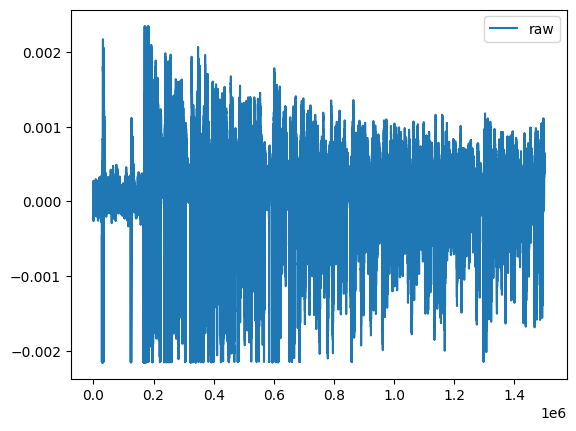

In [ ]:
import matplotlib.pyplot as plt

plt.plot(raw_lfp_scaled[:,0], label = "scaled")

plt.legend()
plt.show()
plt.plot(raw_lfp[:,0],label = "raw")
plt.legend()
plt.show()

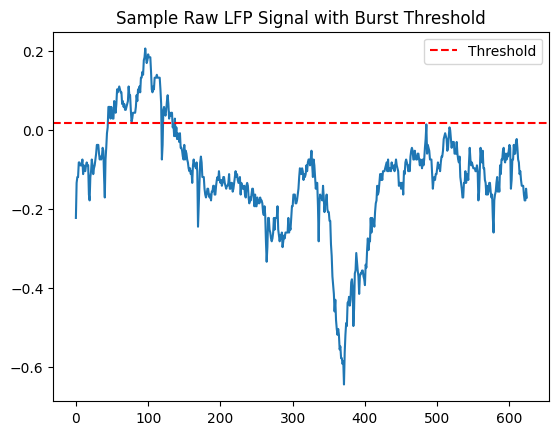

In [ ]:
import matplotlib.pyplot as plt

signal = raw_lfp_scaled[:625,0]
thresh = np.percentile(np.abs(signal), 95)  # Top 5% of values

threshold = threshold* np.std(sample_ch)

plt.plot(sample_ch)
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title("Sample Raw LFP Signal with Burst Threshold")
plt.show()


In [ ]:
from scipy.signal import butter, filtfilt
from scipy.stats import kurtosis, skew, mode, entropy
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import numpy as np
import pandas as pd

# Feature extractor from raw signal
def raw_burst_features(window, bins=3, burst_thresh_factor=1, alpha=1):
    feats = []
    for ch in range(window.shape[1]):
        signal = window[:, ch]
        T = signal.shape[0]
        split_points = np.linspace(0, T, bins + 1, dtype=int)

        thresh = np.percentile(np.abs(signal), 95)
        burst_counts = [
            alpha * (np.count_nonzero(signal[split_points[i]:split_points[i+1]] > thresh))
            for i in range(bins)
        ]

        prob_density, _ = np.histogram(signal, bins=50, density=True)
        prob_density += 1e-12
        ent = entropy(prob_density)

        stats = [
            np.mean(signal), np.std(signal), np.min(signal), np.max(signal),
            np.log1p(np.sum(signal ** 2)), mode(signal, keepdims=True).mode[0],
            skew(signal), kurtosis(signal),
            ((np.diff(np.sign(signal)) != 0).sum()) / len(signal),  # zero-cross rate
            ent
        ]

        feats.append(stats)# + burst_counts)

    return np.concatenate(feats).astype(np.float32)

# Parallel feature extraction
def process_window_raw(window):
    return raw_burst_features(window)

# Parameters
fs = 2500
window_size = int(fs * 0.25)
step = window_size // 2
lfp_filtered = raw_lfp_scaled[:, top_n_indices]

# Generate windows
lfp_windows = [
    lfp_filtered[start:start + window_size]
    for start in range(0, lfp_filtered.shape[0] - window_size, step)
]

# Extract features
print(f"Processing {len(lfp_windows)} bins using {cpu_count()} cores...")
with Pool(processes=cpu_count()) as pool:
    X_raw_features = list(tqdm(pool.imap(process_window_raw, lfp_windows), total=len(lfp_windows)))




Processing 4806 bins using 8 cores...


100%|██████████| 4806/4806 [02:44<00:00, 29.23it/s]


In [ ]:
len(X_raw_features[0])

832

In [ ]:
X = np.array(X_raw_features, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print("Preprocessing complete. X.shape =", X.shape, "| y.shape =", y.shape)

Preprocessing complete. X.shape = (4806, 640) | y.shape = (4806,)
